In [1]:
import torch
import matplotlib.pyplot as plt

from models import LocallyWeightedCNP,CNP,LW_VQCNP,LW_VQCNP_2, ProMP,rbf
import data
from ipywidgets import interact, FloatSlider

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Initialize the ProMP model with appropriate dimensions.
promp_model = ProMP(n_dims=2, n_basis=10, kernel_range=(0, 1), kernel_width=None, amp=1.0, y_std=1e-4, prior_width=1.0)

In [3]:
trainset = data.GridDataset_tp()
len(trainset.data[:][2])

200

In [4]:
trainset = data.GridDataset()

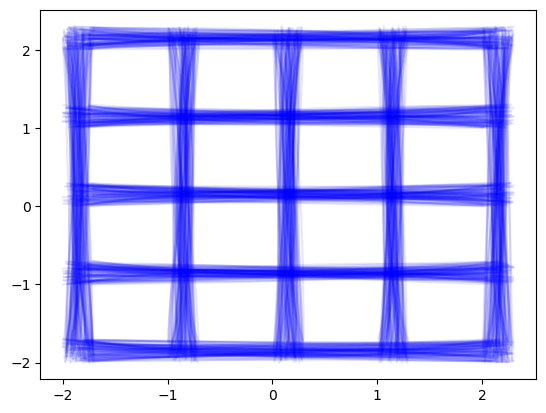

In [4]:
for d in trainset.data:
    plt.plot(d[:,2], d[:,3], c='b', alpha=0.1)

In [5]:
#model = LW_VQCNP_2((1, 2), hidden_size=256, num_hidden_layers=6, min_std=0.0001).to(device)
model = LocallyWeightedCNP((1, 3), hidden_size=256, num_hidden_layers=6, min_std=0.0001,drop_out_rate=0.2).to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
model_bad=CNP((1, 3), hidden_size=256, num_hidden_layers=6, min_std=0.0001).to(device)
learning_rate = 1e-4
optimizer2 = torch.optim.Adam(model_bad.parameters(), lr=learning_rate)


torch.Size([16, 9, 3]) torch.Size([16, 17, 3]) torch.Size([16, 9]) torch.Size([16, 17])


(-2.2, 2.2)

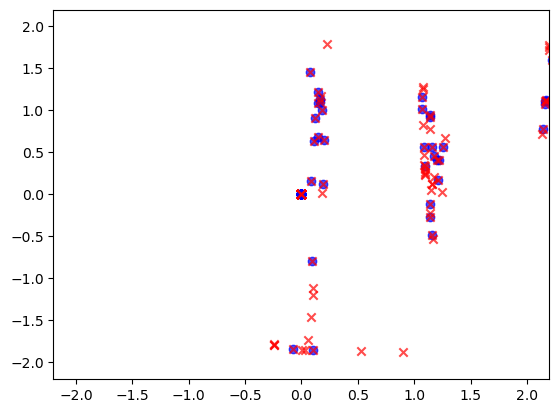

In [7]:
x_t, y_t, x_mask, y_mask = trainset.get_sample(16, max_context=10, max_target=10)
print(x_t.shape, y_t.shape, x_mask.shape, y_mask.shape)
for i in range(8):
    plt.scatter(x_t[i, :, 1], x_t[i, :, 2], marker="o", c="b", alpha=0.7)
    plt.scatter(y_t[i, :, 1], y_t[i, :, 2], marker="x", c="r", alpha=0.7)
    #plt.scatter(x_t[i, :, 1], x_t[i, :, 2], marker="o", c="b", alpha=0.7)
    #plt.scatter(y_t[i, :, 1], y_t[i, :, 2], marker="x", c="r", alpha=0.7)
plt.xlim((-2.2, 2.2))
plt.ylim((-2.2, 2.2))


In [6]:
model.load_state_dict(torch.load("cnp6.pt"))


<All keys matched successfully>

In [18]:
model_bad.load_state_dict(torch.load("cnp.pt"))

RuntimeError: Error(s) in loading state_dict for CNP:
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.0.bias". 
	size mismatch for encoder.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([256, 4]).

In [13]:
loss_checkpoint = 1000
loss_inform_checkpoint = 1000
plot_checkpoint = 10000

avg_loss = 0.0
for step in range(2000000):
    x_t, y_t, x_m, y_m, source_labels = trainset.get_sample_VQ(100, max_context=5, max_target=14)
    x_t = x_t.to(device)
    y_t = y_t.to(device)
    x_m = x_m.to(device)
    y_m = y_m.to(device)
    source_labels=source_labels.to(device)
    optimizer.zero_grad()
    loss = model.nll_loss(x_t, y_t[..., :1], y_t[..., 1:], x_m, y_m,primitive_index = source_labels)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()

    if step % 1000 == 0:
        print(f"Step {step}, loss: {avg_loss / 1000}")
        avg_loss = 0.0

    if step % 10000 == 0:
        torch.save(model.state_dict(), 'cnp2.pt')


Step 0, loss: -0.0020084264278411863
Step 1000, loss: -1.8849367627501488
Step 2000, loss: -1.8488089953847229
Step 3000, loss: -1.8851232570714782
Step 4000, loss: -1.9099580213427543
Step 5000, loss: -1.802029629558325
Step 6000, loss: -1.893475364640355
Step 7000, loss: -1.8988070013783873
Step 8000, loss: -1.9129396015778184
Step 9000, loss: -1.906984174862504
Step 10000, loss: -1.8888970695436
Step 11000, loss: -1.8784497139118612
Step 12000, loss: -1.9198412779569627
Step 13000, loss: -1.9225630716867745
Step 14000, loss: -1.9298372931964696
Step 15000, loss: -1.9198372781202198
Step 16000, loss: -1.912172072634101
Step 17000, loss: -1.9245991382449865
Step 18000, loss: -1.96612134963274
Step 19000, loss: -1.9215727967265994
Step 20000, loss: -1.9198085136935115
Step 21000, loss: -1.9089544620849193
Step 22000, loss: -1.938334861714393
Step 23000, loss: -1.9681138801798224
Step 24000, loss: -1.8940573036670685
Step 25000, loss: -1.9088153107389807
Step 26000, loss: -1.97740316601

KeyboardInterrupt: 

In [6]:
loss_checkpoint = 1000
loss_inform_checkpoint = 1000
plot_checkpoint = 10000

avg_loss = 0.0
for step in range(2000000):
    x_t, y_t, x_m, y_m = trainset.get_sample(100, max_context=5, max_target=10)
    x_t = x_t.to(device)
    y_t = y_t.to(device)
    x_m = x_m.to(device)
    y_m = y_m.to(device)
    optimizer.zero_grad()
    #print(x_t.shape, y_t.shape, x_m.shape, y_m.shape)
    loss = model.nll_loss(x_t, y_t[..., :1], y_t[..., 1:], x_m, y_m)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()

    if step % 1000 == 0:
        print(f"Step {step}, loss: {avg_loss / 1000}")
        avg_loss = 0.0

    if step % 10000 == 0:
        torch.save(model.state_dict(), 'cnp6.pt')


Step 0, loss: 0.002307222843170166
Step 1000, loss: 0.7631915859282017
Step 2000, loss: 0.23236320586114198
Step 3000, loss: -0.28302207612013447
Step 4000, loss: -0.7680480440254324
Step 5000, loss: -1.018711264193058
Step 6000, loss: -1.0819136488363146
Step 7000, loss: -1.1182795561850072
Step 8000, loss: -1.171464266359806
Step 9000, loss: -1.134725807607174
Step 10000, loss: -1.2205251693725585
Step 11000, loss: -1.1938112575411797
Step 12000, loss: -1.242144894182682
Step 13000, loss: -1.2145265782661736
Step 14000, loss: -1.1342584348395466
Step 15000, loss: -1.2126849962323905
Step 16000, loss: -1.2100343319177627
Step 17000, loss: -1.2708751771450042
Step 18000, loss: -1.2894216743707656


KeyboardInterrupt: 

tensor([[0.4309, 0.4915],
        [0.4335, 0.4947],
        [0.4364, 0.4982],
        [0.4393, 0.5017],
        [0.4422, 0.5051],
        [0.4453, 0.5086],
        [0.4483, 0.5121],
        [0.4514, 0.5155],
        [0.4548, 0.5190],
        [0.4582, 0.5226],
        [0.4617, 0.5262],
        [0.4652, 0.5298],
        [0.4687, 0.5334],
        [0.4722, 0.5370],
        [0.4757, 0.5407],
        [0.4792, 0.5443],
        [0.4827, 0.5479],
        [0.4862, 0.5515],
        [0.4898, 0.5550],
        [0.4934, 0.5586],
        [0.4971, 0.5622],
        [0.5008, 0.5659],
        [0.5045, 0.5697],
        [0.5084, 0.5737],
        [0.5123, 0.5776],
        [0.5162, 0.5815],
        [0.5201, 0.5855],
        [0.5241, 0.5895],
        [0.5280, 0.5935],
        [0.5320, 0.5975],
        [0.5362, 0.6014],
        [0.5406, 0.6051],
        [0.5449, 0.6089],
        [0.5493, 0.6126],
        [0.5537, 0.6164],
        [0.5584, 0.6199],
        [0.5632, 0.6237],
        [0.5681, 0.6276],
        [0.5

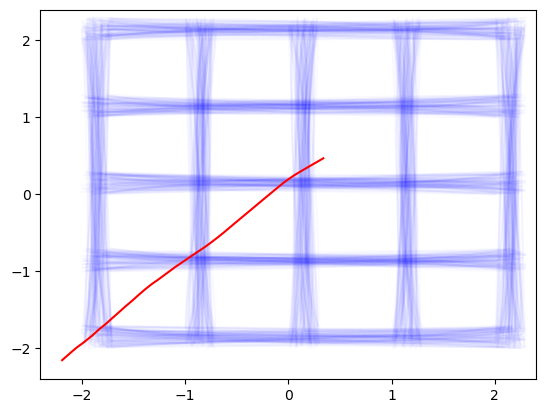

In [11]:
observation = torch.tensor([[0.0,0,-8/3,-8/3]]).unsqueeze(0).to(device)# 3.cüyü 0,1,-2,-2
# Convert manual_dropout_mask to a tensor
manual_dropout_mask = torch.tensor([[1, 0, 1, 1]]).unsqueeze(0).to(device)
# observation = torch.tensor([[0.0, -1.85, 0.15]]).unsqueeze(0)
target = torch.linspace(0.0, 1.0, 200).unsqueeze(-1).unsqueeze(0).to(device)
with torch.no_grad():
    #model.weight_std = torch.tensor(0.5)
    model.eval()
    mean, std = model(observation, target, locally_weighted=True,aggregation_std=0.2,manual_dropout_mask=manual_dropout_mask)
    #mean, std = model(observation, target, locally_weighted=True,aggregation_std=0.5,primitive_index=torch.tensor([0,0]).to(device))
    #mean, std = model(observation, target)
mean.squeeze_(0)
std.squeeze_(0)
std=std**0.5
# Calculate the mean plus and minus the standard deviation
mean_plus_std = mean + std
mean_minus_std = mean - std


# print("Mean head:", mean[:5])
# print("STD head:", std[:5])
# print("mean_plus_std head:", mean_plus_std[:5])
# print("mean_minus_std head:", mean_minus_std[:5])

# Plot the mean line
# Plot the standard deviation as a shaded region
#plt.fill_between(mean[:, 1].cpu(), mean_minus_std[:, 0].cpu(), mean_plus_std[:, 0].cpu(), color='r', alpha=0.2)

for d in trainset.data:
    plt.plot(d[:, 2], d[:, 3], c='b', alpha=0.025)
plt.scatter(observation[0, :, 2].cpu(), observation[0, :, 3].cpu(), marker="x", c="g", alpha=0.7)
plt.plot(mean[:, 0].cpu(), mean[:, 1].cpu(), c='r')
plt.xlim((-2.4, 2.4))
plt.ylim((-2.4, 2.4))
std

In [21]:
std**0.5

tensor([[0.2031, 0.2833],
        [0.2030, 0.2831],
        [0.2029, 0.2830],
        [0.2027, 0.2828],
        [0.2025, 0.2827],
        [0.2024, 0.2825],
        [0.2022, 0.2824],
        [0.2020, 0.2822],
        [0.2018, 0.2820],
        [0.2016, 0.2818],
        [0.2014, 0.2816],
        [0.2012, 0.2814],
        [0.2010, 0.2812],
        [0.2007, 0.2810],
        [0.2005, 0.2808],
        [0.2002, 0.2806],
        [0.2000, 0.2803],
        [0.1998, 0.2801],
        [0.1995, 0.2798],
        [0.1992, 0.2796],
        [0.1990, 0.2793],
        [0.1987, 0.2791],
        [0.1985, 0.2788],
        [0.1982, 0.2786],
        [0.1978, 0.2783],
        [0.1975, 0.2780],
        [0.1972, 0.2778],
        [0.1969, 0.2775],
        [0.1965, 0.2773],
        [0.1962, 0.2770],
        [0.1959, 0.2767],
        [0.1955, 0.2765],
        [0.1952, 0.2762],
        [0.1949, 0.2760],
        [0.1945, 0.2757],
        [0.1941, 0.2755],
        [0.1938, 0.2753],
        [0.1934, 0.2750],
        [0.1

In [8]:
def initialize_external_weights(n_batch, n_target, weight_values):
    """
    Initialize external weights using provided weight values.

    Parameters:
    - n_batch: Batch size.
    - n_target: Number of target points.
    - weight_values: An array of weight values, length should be equal to n_context.

    Returns:
    - A tensor of external weights with shape (n_batch, n_target, n_context).
    """
    n_context = len(weight_values)
    # Convert the weight values to a tensor and reshape it to match required dimensions
    weight_values_tensor = torch.tensor(weight_values, dtype=torch.float32).view(1, 1, n_context)
    # Repeat the weight values for each batch and target point
    weights = weight_values_tensor.repeat(n_batch, n_target, 1)

    # Normalize weights across the context dimension
    weights_sum = weights.sum(dim=-1, keepdim=True)
    normalized_weights = weights / weights_sum

    return normalized_weights
# Example parameters
n_batch = 1  # Assuming a single batch
n_target = 200  # Assuming 200 target points
weight_values = [0.25, 0.75]  # Example weights for each context point

# Initialize the external weights
external_weights = initialize_external_weights(n_batch, n_target, weight_values)

external_weights.shape

torch.Size([1, 200, 2])

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, HBox, VBox

# Assuming model, trainset, and device are already defined

# Initial observation
observation = torch.tensor([[0.0,1.0,-1.85, -2],[1.0,0.0, -1, 1]]).unsqueeze(0).to(device)
target = torch.linspace(0, 1, 200).unsqueeze(-1).unsqueeze(0).to(device)

# Function to plot based on given inputs
def plot_graph(aggregation_std=0.5, num_points=2, **kwargs):
    data = []
    for i in range(num_points):
        time_val = kwargs[f"Time {i}"]
        primitive_val = kwargs[f"Primitive {i}"]
        x_val = kwargs[f"X {i}"]
        y_val = kwargs[f"Y {i}"]
        data.append([time_val, primitive_val, x_val, y_val])
        
    observation = torch.tensor(data).unsqueeze(0).to(device)
    
    with torch.no_grad():
        model.eval()
        mean, std = model(observation, target, locally_weighted=True, aggregation_std=aggregation_std,external_weights=external_weights)
        #mean2, std2 = model_bad(observation, target)
        
    mean = mean.squeeze(0)
    std = std.squeeze(0)
    # mean2=mean2.squeeze(0)
    # std2=std2.squeeze(0)

    plt.figure(figsize=(10, 6))
    for d in trainset.data:
        plt.plot(d[:, 2], d[:, 3], c='b', alpha=0.025)
    plt.scatter(observation[0, :, 2].cpu(), observation[0, :, 3].cpu(), marker="o", c="g",s=1000, alpha=0.7)
    plt.plot(mean[:, 0].cpu(), mean[:, 1].cpu(), c='r',label='LW-CNP',linewidth=5)
    #plt.plot(mean2[:, 0].cpu(), mean2[:, 1].cpu(), c='g',label='CNP',linewidth=5)
    #for idx, (x, y) in enumerate(zip(mean[:, 0].cpu(), mean[:, 1].cpu())):
        #if idx%10 == 0:
        #    plt.annotate(str(idx), (x, y), fontsize=8, ha='right')

    #plt.text(-2.2, 2.0, f'Aggregation Std: {aggregation_std}', fontsize=12, color='black')
    plt.xlim((-2.4, 2.4))
    plt.ylim((-2.4, 2.4))
    plt.title('LW-CNP(red) vs CNP(green)', fontsize=16, fontweight='bold')
    #plt.legend() 
    plt.show()

# Create interactive widgets
num_points_slider = IntSlider(min=1, max=10, value=2, description="num_points")
aggregation_std_slider = FloatSlider(min=0, max=1, step=0.05, value=0.5, description="aggregation_std")
sliders = [aggregation_std_slider, num_points_slider]

# Create sliders for each point's time, x, and y values
for i in range(4):  # max 10 points
    time_slider = FloatSlider(min=0, max=1, step=0.05, value=0 if i >= 2 else observation[0, i, 0].item(), description=f"Time {i}")
    primitive_slider = IntSlider(min=0, max=1, value=0 if i >= 2 else int(observation[0, i, 1].item()), description=f"Primitive {i}")  # NEW
    x_slider = FloatSlider(min=-2.4, max=2.4, step=0.05, value=0 if i >= 2 else observation[0, i, 2].item(), description=f"X {i}")
    y_slider = FloatSlider(min=-2.4, max=2.4, step=0.05, value=0 if i >= 2 else observation[0, i, 3].item(), description=f"Y {i}")
    
    sliders.extend([time_slider, primitive_slider, x_slider, y_slider])  # UPDATED

# Create a GUI layout for the widgets
box_layout = VBox([HBox(sliders[i:i+3]) for i in range(0, len(sliders), 4)])

# Create the interactive plot
interact(plot_graph, **{slider.description: slider for slider in sliders}, continuous_update=False);


interactive(children=(FloatSlider(value=0.5, description='aggregation_std', max=1.0, step=0.05), IntSlider(val…

In [ ]:
def plot_graph(aggregation_std=0.5, num_points=2, **kwargs):
    data = []
    for i in range(num_points):
        time_val = kwargs[f"Time {i}"]
        primitive_val = kwargs[f"Primitive {i}"]
        x_val = kwargs[f"X {i}"]
        y_val = kwargs[f"Y {i}"]
        data.append([time_val, primitive_val, x_val, y_val])
        
    observation = torch.tensor(data).unsqueeze(0).to(device)
    
    with torch.no_grad():
        model.eval()
        mean, std = model(observation, target, locally_weighted=True, aggregation_std=aggregation_std)
        
    mean = mean.squeeze(0)
    std = std.squeeze(0)

    plt.figure(figsize=(10, 6))
    for d in trainset.data:
        plt.plot(d[:, 2], d[:, 3], c='b', alpha=0.025)
    plt.scatter(observation[0, :, 2].cpu(), observation[0, :, 3].cpu(), marker="o", c="g", s=1000, alpha=0.7)
    plt.plot(mean[:, 0].cpu(), mean[:, 1].cpu(), c='r', label='LW-CNP', linewidth=5)

    plt.xlim((-2.4, 2.4))
    plt.ylim((-2.4, 2.4))
    plt.title('LW-CNP(red) vs CNP(green)', fontsize=16, fontweight='bold')
    plt.show()


In [10]:
mean[:, 0].cpu()

NameError: name 'mean' is not defined

In [7]:
torch.save(model.state_dict(), 'cnp4.pt')